# TODO  
## Write C functions (tv_denoise, tv_denoise_core, tv_denoise_core_org)  
## Understand the difference between tv_denoise_core, tv_denoise_core_org  
## Add legends to the pics
## ...

In [16]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib
import cv2
# import visvis as vv
%matplotlib inline

# Some funcs from tools.c that we use (done)

In [17]:
#matlab function
def TVdenoise(noisy_image, delta, eps_rel = 1e-3):
    """
    noisy image - np array !!!
    delta = tau * sqrt(M * N) * sigma
        -tau - less than 1 (0.85 in paper)
        -M, N - size of immage
        -sigma - std of the noise in the pixel
    eps_rel - relative accuracy 1e-3 by default
    """
    alpha = np.sum(noisy_image.flatten()) / len(noisy_image)
    X = alpha * np.ones(noisy_image.shape)
    mdelta = np.linalg.norm(X - noisy_image, 'fro')
    if mdelta < delta:
        #maybe put some info here like in paper
        return
    elif mdelta < 1.1 * delta:
        #maybe throw warning like in paper
        print('Convergence problems may arise')
    R = max(noisy_image.flatten())
    mn = noisy_image.shape[0] * noisy_image.shape[1]
    epsilon = R * mn * eps_rel
    mu = epsilon / mn
    Lmu = 8 / mu
    N = np.ceil(2 * np.sqrt(8 * mn) * delta / epsilon).astype(int) # maxiter as far as I understood
    print(N)
    X = tv_denoise(noisy_image, delta, epsilon, Lmu, mu, 100, 0) # rewrite C func!!!!
    return X

# TVdenoise main part in Matlab is done but C function has to be written!!

In [18]:
image = cv2.imread('Pirate.tif', 0)

In [19]:
def create_noisy_image(image, noise_std):
    noisy_image = image + np.random.normal(scale=noise_std, size=image.shape)
    return np.clip(noisy_image, 0, 255)

In [20]:
def plot_image(image):
    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'gray')

In [21]:
noisy_image = create_noisy_image(image, 25)

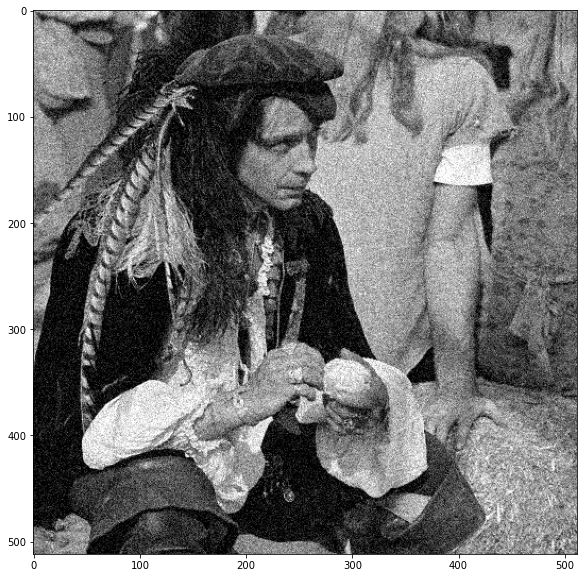

In [22]:
plot_image(noisy_image)

In [28]:
def TVdenoise_demo(image_path, noise_std, tau):
    image = cv2.imread('Pirate.tif', 0)
    create_noisy_image(image, noise_std)
    plot_image(image)
    plot_image(noisy_image)
    delta = tau * np.sqrt(noisy_image.shape[0] * noisy_image.shape[1]) * noise_std
    denoised_image = TVdenoise(noisy_image, delta) # rewrite C func! may be add info parameter like in paper
    denoised_image = denoised_image.reshape((512, 512)) # do M x N
    #actually TVdenoise is done, but it has C function insude, that should be rewritten
    plot_image(denoised_image)

In [29]:
def tv_denoise(noisy_img, delta, eps, L, mu, maxiter, typpe): # typpe = type in order to not to use keyword, in paper type = 0
    """
    Just stupid rewrite the C code, but thees three params should be returned from core func
    """
    x = np.zeros(noisy_img.shape)
    kf = 0
    epsilon_kf = 0
    m = noisy_img.shape[0]
    n = noisy_img.shape[1]
    noisy_img = noisy_img.flatten()
    if typpe == 1:
        restored_img = tv_denoise_core(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf)
        return restored_img
    else:
        restored_img = tv_denoise_core_org(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf)
        return restored_img


In [32]:
def tv_denoise_core_org(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf):
        pobj = 0
        dobj = 0
        mn = m * n
        one = 1
        mL = -L
        A_kp1 = 0.5

        wk = np.zeros(mn)
        x = noisy_img.flatten()
        uij = np.zeros(2)
        for k in range(maxiter):
            print(f'{k} iteration')
            df = np.zeros(mn)
            pobj = 0
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.linalg.norm(uij)
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij = uij / c2
                    
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_img) - delta * np.linalg.norm(df)
            print(pobj - dobj)
            if pobj - dobj < eps:
                break
        #step 2
            y_k = (L * (x - noisy_img) - df)/ (max(L, np.linalg.norm(L * (x - noisy_img) - df) / delta)) + noisy_img
        #step3
            wk += ((k + 1) / 2) * df
            zk = -wk / max(L, np.linalg.norm(wk) / delta) + noisy_img
        #step4
            x = 2 /(k + 3) *zk + (k + 1)/(k + 3) * y_k
        return x

472
0 iteration
11126290.07731708
1 iteration
11096380.434681676
2 iteration
11057204.457409466
3 iteration
11008738.228173176
4 iteration
10950573.839216447
5 iteration
10882703.665997745
6 iteration
10805043.67519899
7 iteration
10717657.136081705
8 iteration
10620304.808485845
9 iteration
10512827.119991845
10 iteration
10395421.380934367
11 iteration
10268177.728917431
12 iteration
10131266.794975307
13 iteration
9984995.634832414
14 iteration
9829053.842718055
15 iteration
9663533.737370603
16 iteration
9488972.401000949
17 iteration
9304780.902031893
18 iteration
9113210.696367638
19 iteration
8912869.593315039
20 iteration
8705580.488332616
21 iteration
8492160.114726061
22 iteration
8272375.732142756
23 iteration
8048033.978615683
24 iteration
7819660.693119587
25 iteration
7587502.447819022
26 iteration
7353259.7784968205
27 iteration
7118311.95842259
28 iteration
6883316.383230634
29 iteration
6650838.6620934745
30 iteration
6421427.317122207
31 iteration
6196793.851986661
32

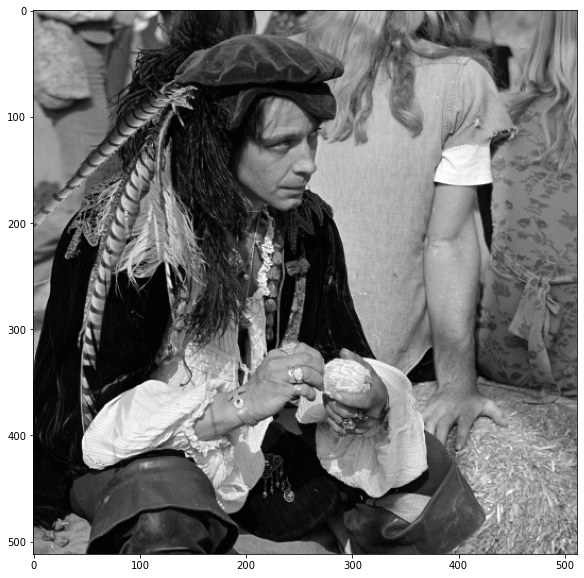

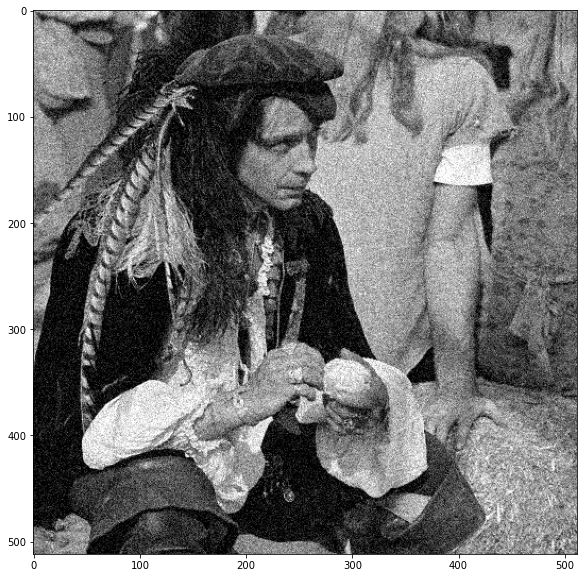

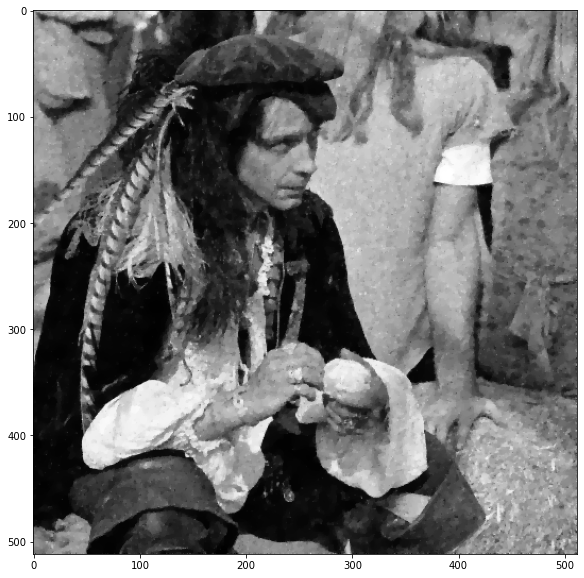

In [33]:
TVdenoise_demo('Pirate.tif', 25, 0.85) # add legends to  pictures!!!

# TVdenoise_demo matlab script from paper (done)

In [9]:
rows, cols = noisy_image.shape


In [11]:
cols

512

In [13]:
diffs = []

In [14]:
diffs += [noisy_image[0:rows-1, 1:cols] - noisy_image[0:rows-1, 0:cols-1], 
          noisy_image[1:rows, 0:cols-1] - noisy_image[0:rows-1, 0:cols-1]]
length = diffs[0].shape[0]*diffs[1].shape[1]
stacked = vstack([reshape(diff, (1, length)) for diff in diffs])

NameError: name 'mat' is not defined

In [ ]:
print(sum(norm(stacked, p=2, axis=0)))

# tv_denoise.c  более менее переписана, но подумать о том, как возвращать значения

# tv_denoise_core_org.c